In [2]:
import torch
import torch.nn as nn
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from dataclasses import dataclass
from typing import Callable
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from lime import lime_image
from skimage.segmentation import mark_boundaries
from scipy.stats import pearsonr
from tqdm import tqdm
from util.torch_architecture import CNN
from util.cnn_parameters import IMG_HEIGHT, IMG_WIDTH, TEST_IMAGES_PATH, TRAIN_IMAGES_PATH

IMG_SIZE = (128, 128)
BATCH_SIZE = 32


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cpu


In [4]:
DAUC = "DAUC"
IAUC = "IAUC"
DELETION = "Deletion"
INSERTION = "Insertion"

In [5]:
class CatDogDataset(Dataset):
    def __init__(self, dataframe, root_dir, transform=None):
        self.dataframe = dataframe
        self.root_dir = root_dir
        self.transform = transform
        self.class_to_idx = {"dog": 1, "cat": 0}

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.dataframe.iloc[idx]["image"])
        image = Image.open(img_name).convert("RGB")
        label = self.class_to_idx[self.dataframe.iloc[idx]["class"]]

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.float32)

def load_model():
    """Load the pretrained model"""
    model = CNN()
    model.load_state_dict(torch.load("cats_dogs_cnn.pth", map_location=device))
    model.to(device)
    model.eval()
    return model

def load_data():
    """Load and prepare data for training and validation"""
    file_names = os.listdir(TRAIN_IMAGES_PATH)
    labels = ["dog" if "dog" in name else "cat" for name in file_names]
    df = pd.DataFrame({"image": file_names, "class": labels})
    
    train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)
    
    val_transforms = transforms.Compose([
        transforms.Resize(IMG_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])
    ])
    
    val_dataset = CatDogDataset(val_df, TRAIN_IMAGES_PATH, transform=val_transforms)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
    
    print(f"Validation size: {len(val_dataset)}")
    return val_dataset, val_loader

def prepare_image(img_path):
    """Prepare a single image for model input"""
    transform = transforms.Compose([
        transforms.Resize(IMG_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])
    ])
    
    image = Image.open(img_path).convert("RGB")
    return transform(image).unsqueeze(0).to(device)


In [6]:
lime_normalize = transforms.Normalize(mean=[0.5], std=[0.5])
lime_to_tensor = transforms.ToTensor()

lime_normalize = transforms.Normalize(mean=[0.5], std=[0.5])
lime_to_tensor = transforms.ToTensor()

@torch.no_grad()
def predict_fn(images):
    model.eval()

    batch_tensors = []
    for img_np in images:
        tensor = lime_to_tensor(img_np).to(device)
        normalized_tensor = lime_normalize(tensor)
        batch_tensors.append(normalized_tensor)

    batch = torch.stack(batch_tensors)

    outputs = model(batch)

    probs_dog = torch.sigmoid(outputs).detach().cpu().numpy()
    probs_cat = 1 - probs_dog

    return np.concatenate([probs_cat, probs_dog], axis=1)

def get_lime_explanation(image_tensor, explainer, model):
    image_pil = transforms.ToPILImage()(image_tensor.squeeze(0))
    
    explanation = explainer.explain_instance(
        np.array(image_pil),
        predict_fn,
        top_labels=2,
        hide_color=0,
        num_samples=1000,
    )
    
    with torch.no_grad():
        output = model(image_tensor)
        pred = output.item()
    predicted_class = 1 if pred >= 0.5 else 0
    
    return explanation, output, predicted_class


In [7]:
@dataclass
class CorrMetricsParams:
    perturbed_image: Callable
    mask: Callable
    label: str

def cloned_image(input_image):
    return input_image.clone()

def zeros_image(input_image):
    return torch.zeros_like(input_image)

def mask_set_zero(importance_map, num_remove, sorted_indices):
    mask = torch.ones_like(importance_map.view(-1))
    mask[sorted_indices[:num_remove]] = 0
    return mask

def mask_set_one(importance_map, num_add, sorted_indices):
    mask = torch.zeros_like(importance_map.view(-1))
    mask[sorted_indices[:num_add]] = 1
    return mask

del_corr = CorrMetricsParams(
    perturbed_image=cloned_image,
    mask=mask_set_zero,
    label="removed"
)

ins_corr = CorrMetricsParams(
    perturbed_image=zeros_image,
    mask=mask_set_one,
    label="added"
)

metrics_params = {
    DAUC: True,
    IAUC: False,
    DELETION: del_corr,
    INSERTION: ins_corr,
}

def apply_mask(input_image, mask, importance_map):
    mask_reshaped = mask.view(importance_map.shape).unsqueeze(0)
    mask_expanded = mask_reshaped.repeat(3, 1, 1)
    return input_image * mask_expanded

def get_num_pixels(input_image):
    return input_image.shape[2] * input_image.shape[3]

def get_lime_importance_map(explanation, predicted_class):
    segments = explanation.segments
    features = dict(explanation.local_exp[predicted_class])

    importance_map_np = np.zeros(segments.shape)
    for segment_id, importance in features.items():
        importance_map_np[segments == segment_id] = importance

    return torch.tensor(importance_map_np, dtype=torch.float32, device=device)


In [8]:
def compute_lime_auc(model, input_image, output, explanation, predicted_class, auc, steps=10, plot=False):
    model.eval()
    
    importance_map = get_lime_importance_map(explanation, predicted_class)
    sorted_indices = importance_map.view(-1).argsort(descending=metrics_params[auc])
    
    perturbed_image = cloned_image(input_image)
    perturbation_curve = []
    num_pixels = get_num_pixels(input_image)
    
    for step in range(1, steps + 1):
        num_remove = int((step / steps) * num_pixels)
        mask = mask_set_zero(importance_map, num_remove, sorted_indices)
        perturbed_image = apply_mask(input_image, mask, importance_map)
        
        with torch.no_grad():
            output = model(perturbed_image)
        
        perturbation_curve.append(output.item())
    
    x_vals = np.linspace(0, 1, steps)
    auc_value = np.trapz(perturbation_curve, x_vals)
    
    if plot:
        plt.figure(figsize=(6, 4))
        plt.plot(x_vals, perturbation_curve, marker='o', label="Score Drop")
        plt.xlabel("Fraction of pixels occluded")
        plt.ylabel("Model Output Score")
        plt.title(f"LIME {auc} Evaluation (AUC = {auc_value:.4f})")
        plt.legend()
        plt.show()
    
    return auc_value, perturbation_curve

def compute_lime_ins_del_correlation(model, input_image, output, explanation, predicted_class, corr, steps=10, plot=False):
    model.eval()
    
    importance_map = get_lime_importance_map(explanation, predicted_class)
    sorted_indices = importance_map.view(-1).argsort(descending=True)
    
    perturbed_image = metrics_params[corr].perturbed_image(input_image)
    perturbation_curve = []
    num_pixels = get_num_pixels(input_image)
    
    for step in range(1, steps + 1):
        num_remove = int((step / steps) * num_pixels)
        
        mask = metrics_params[corr].mask(importance_map, num_remove, sorted_indices)
        perturbed_image = apply_mask(input_image, mask, importance_map)
        
        with torch.no_grad():
            output = model(perturbed_image)
        
        perturbation_curve.append(output.item())
    
    x_vals = np.linspace(0, 1, steps)
    correlation, _ = pearsonr(x_vals, perturbation_curve)
    
    if plot:
        plt.figure(figsize=(6, 4))
        plt.plot(x_vals, perturbation_curve, marker='o', label="Score Drop")
        plt.xlabel(f"Fraction of pixels {metrics_params[corr].label}")
        plt.ylabel("Model Output Score")
        plt.title(f"LIME {corr} Correlation = {correlation:.4f}")
        plt.legend()
        plt.show()
    
    return correlation

def compute_lime_average_drop(model, input_image, output, explanation, predicted_class, steps=10, plot=False):
    model.eval()
    
    importance_map = get_lime_importance_map(explanation, predicted_class)
    sorted_indices = importance_map.view(-1).argsort(descending=True)
    
    perturbed_image = cloned_image(input_image)
    drop_curve = []
    initial_output = output.item()
    num_pixels = get_num_pixels(input_image)
    
    for step in range(1, steps + 1):
        num_remove = int((step / steps) * num_pixels)
        
        mask = mask_set_zero(importance_map, num_remove, sorted_indices)
        perturbed_image = apply_mask(input_image, mask, importance_map)
        
        with torch.no_grad():
            output = model(perturbed_image)
        
        drop = initial_output - output.item()
        drop_curve.append(drop)
    
    average_drop = np.mean(drop_curve)
    
    if plot:
        plt.figure(figsize=(6, 4))
        plt.plot(np.linspace(0, 1, steps), drop_curve, marker='o', label="Output Drop")
        plt.xlabel("Fraction of pixels removed")
        plt.ylabel("Drop in model output")
        plt.title(f"LIME Average Drop = {average_drop:.4f}")
        plt.legend()
        plt.show()
    
    return average_drop

def compute_lime_increase_in_confidence(model, input_image, output, explanation, predicted_class, steps=10, plot=False):
    model.eval()
    
    importance_map = get_lime_importance_map(explanation, predicted_class)
    sorted_indices = importance_map.view(-1).argsort(descending=True)
    
    perturbed_image = zeros_image(input_image)
    confidence_curve = []
    num_pixels = get_num_pixels(input_image)
    
    for step in range(1, steps + 1):
        num_add = int((step / steps) * num_pixels)
        
        mask = mask_set_one(importance_map, num_add, sorted_indices)
        perturbed_image = apply_mask(input_image, mask, importance_map)
        
        with torch.no_grad():
            output = model(perturbed_image)
        
        confidence = torch.sigmoid(output).item()
        confidence_curve.append(confidence)
    
    increase_in_confidence = confidence_curve[-1] - confidence_curve[0]
    
    if plot:
        plt.figure(figsize=(6, 4))
        plt.plot(np.linspace(0, 1, steps), confidence_curve, marker='o', label="Confidence")
        plt.xlabel("Fraction of pixels added")
        plt.ylabel("Confidence (probability of positive class)")
        plt.title(f"LIME Increase in Confidence = {increase_in_confidence:.4f}")
        plt.legend()
        plt.show()
    
    return increase_in_confidence

In [9]:
def batch_lime_metrics(model, dataset, num_images=200, steps=10):
    explainer = lime_image.LimeImageExplainer()
    
    indices = list(range(min(num_images, len(dataset))))
    
    dauc_values = []
    iauc_values = []
    deletion_corr_values = []
    insertion_corr_values = []
    avg_drop_values = []
    confidence_incr_values = []
    
    for idx in tqdm(indices, desc="Computing LIME metrics"):
        image_tensor, _ = dataset[idx]
        input_image = image_tensor.unsqueeze(0).to(device)
        
        with torch.no_grad():
            output = model(input_image)
        
        explanation, output, predicted_class = get_lime_explanation(input_image, explainer, model)
        
        dauc_value, _ = compute_lime_auc(model, input_image, output, explanation, predicted_class, auc=DAUC, steps=steps)
        dauc_values.append(dauc_value)
        
        iauc_value, _ = compute_lime_auc(model, input_image, output, explanation, predicted_class, auc=IAUC, steps=steps)
        iauc_values.append(iauc_value)
        
        deletion_corr = compute_lime_ins_del_correlation(model, input_image, output, explanation, predicted_class, corr=DELETION, steps=steps)
        deletion_corr_values.append(deletion_corr)
        
        insertion_corr = compute_lime_ins_del_correlation(model, input_image, output, explanation, predicted_class, corr=INSERTION, steps=steps)
        insertion_corr_values.append(insertion_corr)
        
        avg_drop = compute_lime_average_drop(model, input_image, output, explanation, predicted_class, steps=steps)
        avg_drop_values.append(avg_drop)
        
        confidence_incr = compute_lime_increase_in_confidence(model, input_image, output, explanation, predicted_class, steps=steps)
        confidence_incr_values.append(confidence_incr)
    
    results = {
        "DAUC": np.mean(dauc_values),
        "IAUC": np.mean(iauc_values),
        "Deletion Correlation": np.mean(deletion_corr_values),
        "Insertion Correlation": np.mean(insertion_corr_values),
        "Average Drop": np.mean(avg_drop_values),
        "Increase in Confidence": np.mean(confidence_incr_values)
    }
    
    return results


In [10]:
def visualize_lime_explanation(image_tensor, explanation, predicted_class):
    img_vis = image_tensor.clone().squeeze(0).cpu()
    img_vis = img_vis * 0.5 + 0.5
    img_vis = torch.clamp(img_vis, 0, 1)
    image_pil = transforms.ToPILImage()(img_vis)

    try:
        temp_image, mask = explanation.get_image_and_mask(
            label=predicted_class,
            positive_only=True,
            hide_rest=False,
            num_features=10,
            min_weight=0.01
        )

    except KeyError:
         print(f"Warning: Predicted class {predicted_class} not in explanation labels for visualization.")
         label_to_show = 0 if 0 in explanation.local_exp else (1 if 1 in explanation.local_exp else None)
         if label_to_show is not None:
             print(f"Showing explanation for label {label_to_show} instead.")
             temp_image, mask = explanation.get_image_and_mask(
                 label=label_to_show,
                 positive_only=True,
                 hide_rest=True,
                 num_features=10,
                 min_weight=0.01
             )
         else:
             print("Error: Cannot generate visualization. No valid labels found in explanation.")
             plt.figure(figsize=(6, 5))
             plt.imshow(image_pil)
             plt.title(f"Original Image (Pred: {'Dog' if predicted_class == 1 else 'Cat'})\n(Explanation Failed)")
             plt.axis("off")
             plt.show()
             return

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(image_pil)
    plt.title(f"Original Image (Pred: {'Dog' if predicted_class == 1 else 'Cat'})")
    plt.axis("off")

    plt.subplot(1, 2, 2)

    img_display = temp_image / 255.0 if temp_image.max() > 1 else temp_image
    plt.imshow(mark_boundaries(img_display, mask))
    plt.title("LIME Explanation")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

def visualize_lime_metrics(model, input_image, explanation, output, predicted_class, steps=10):
    plt.figure(figsize=(16, 12))
    
    plt.subplot(2, 3, 1)
    dauc_value, dauc_curve = compute_lime_auc(model, input_image, output, explanation, predicted_class, auc=DAUC, steps=steps)
    plt.plot(np.linspace(0, 1, steps), dauc_curve, marker='o')
    plt.xlabel("Fraction of pixels occluded")
    plt.ylabel("Model Output Score")
    plt.title(f"DAUC = {dauc_value:.4f}")
    
    plt.subplot(2, 3, 2)
    iauc_value, iauc_curve = compute_lime_auc(model, input_image, output, explanation, predicted_class, auc=IAUC, steps=steps)
    plt.plot(np.linspace(0, 1, steps), iauc_curve, marker='o')
    plt.xlabel("Fraction of pixels occluded")
    plt.ylabel("Model Output Score")
    plt.title(f"IAUC = {iauc_value:.4f}")
    
    plt.subplot(2, 3, 3)
    deletion_corr = compute_lime_ins_del_correlation(model, input_image, output, explanation, predicted_class, corr=DELETION, steps=steps)
    x_vals = np.linspace(0, 1, steps)
    plt.plot(x_vals, dauc_curve, marker='o')
    plt.xlabel("Fraction of pixels removed")
    plt.ylabel("Model Output Score")
    plt.title(f"Deletion Correlation = {deletion_corr:.4f}")
    
    plt.subplot(2, 3, 4)
    insertion_corr = compute_lime_ins_del_correlation(model, input_image, output, explanation, predicted_class, corr=INSERTION, steps=steps)
    perturbed_image = zeros_image(input_image)
    insertion_curve = []
    importance_map = get_lime_importance_map(explanation, predicted_class)
    sorted_indices = importance_map.view(-1).argsort(descending=True)
    num_pixels = get_num_pixels(input_image)
    
    for step in range(1, steps + 1):
        num_add = int((step / steps) * num_pixels)
        mask = mask_set_one(importance_map, num_add, sorted_indices)
        perturbed_image = apply_mask(input_image, mask, importance_map)
        with torch.no_grad():
            output_step = model(perturbed_image)
        insertion_curve.append(output_step.item())
    
    plt.plot(x_vals, insertion_curve, marker='o')
    plt.xlabel("Fraction of pixels added")
    plt.ylabel("Model Output Score")
    plt.title(f"Insertion Correlation = {insertion_corr:.4f}")
    
    plt.subplot(2, 3, 5)
    avg_drop = compute_lime_average_drop(model, input_image, output, explanation, predicted_class, steps=steps)
    drop_curve = [output.item() - score for score in dauc_curve]
    plt.plot(x_vals, drop_curve, marker='o')
    plt.xlabel("Fraction of pixels removed")
    plt.ylabel("Drop in model output")
    plt.title(f"Average Drop = {avg_drop:.4f}")
    
    plt.subplot(2, 3, 6)
    confidence_incr = compute_lime_increase_in_confidence(model, input_image, output, explanation, predicted_class, steps=steps)
    confidence_curve = [torch.sigmoid(torch.tensor(score)).item() for score in insertion_curve]
    plt.plot(x_vals, confidence_curve, marker='o')
    plt.xlabel("Fraction of pixels added")
    plt.ylabel("Confidence (probability)")
    plt.title(f"Increase in Confidence = {confidence_incr:.4f}")
    
    plt.tight_layout()
    plt.show()
    
    print("\nLIME Metrics Summary:")
    print(f"DAUC: {dauc_value:.4f}")
    print(f"IAUC: {iauc_value:.4f}")
    print(f"Deletion Correlation: {deletion_corr:.4f}")
    print(f"Insertion Correlation: {insertion_corr:.4f}")
    print(f"Average Drop: {avg_drop:.4f}")
    print(f"Increase in Confidence: {confidence_incr:.4f}")

Validation size: 5000


  0%|          | 0/1000 [00:00<?, ?it/s]

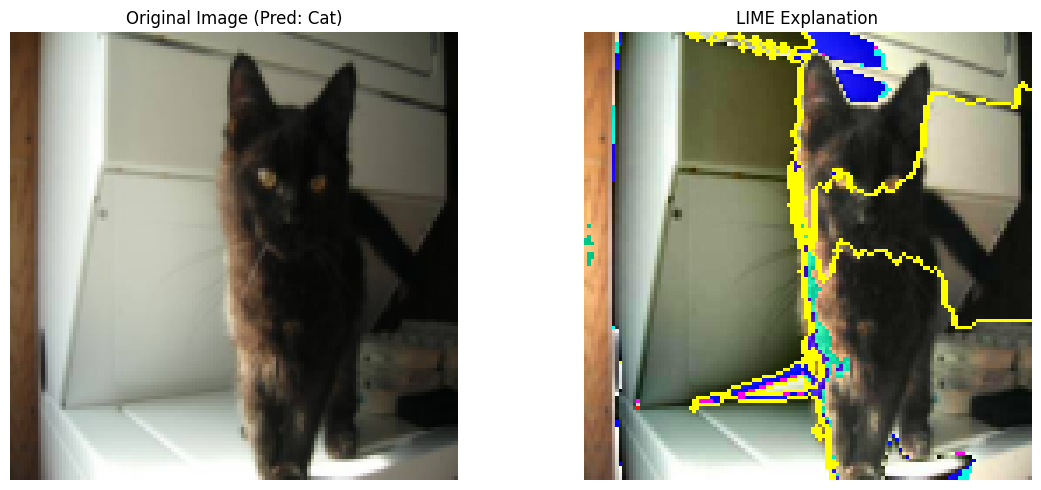

C:\Users\sonbu\AppData\Local\Temp\ipykernel_28716\211464218.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_value = np.trapz(perturbation_curve, x_vals)


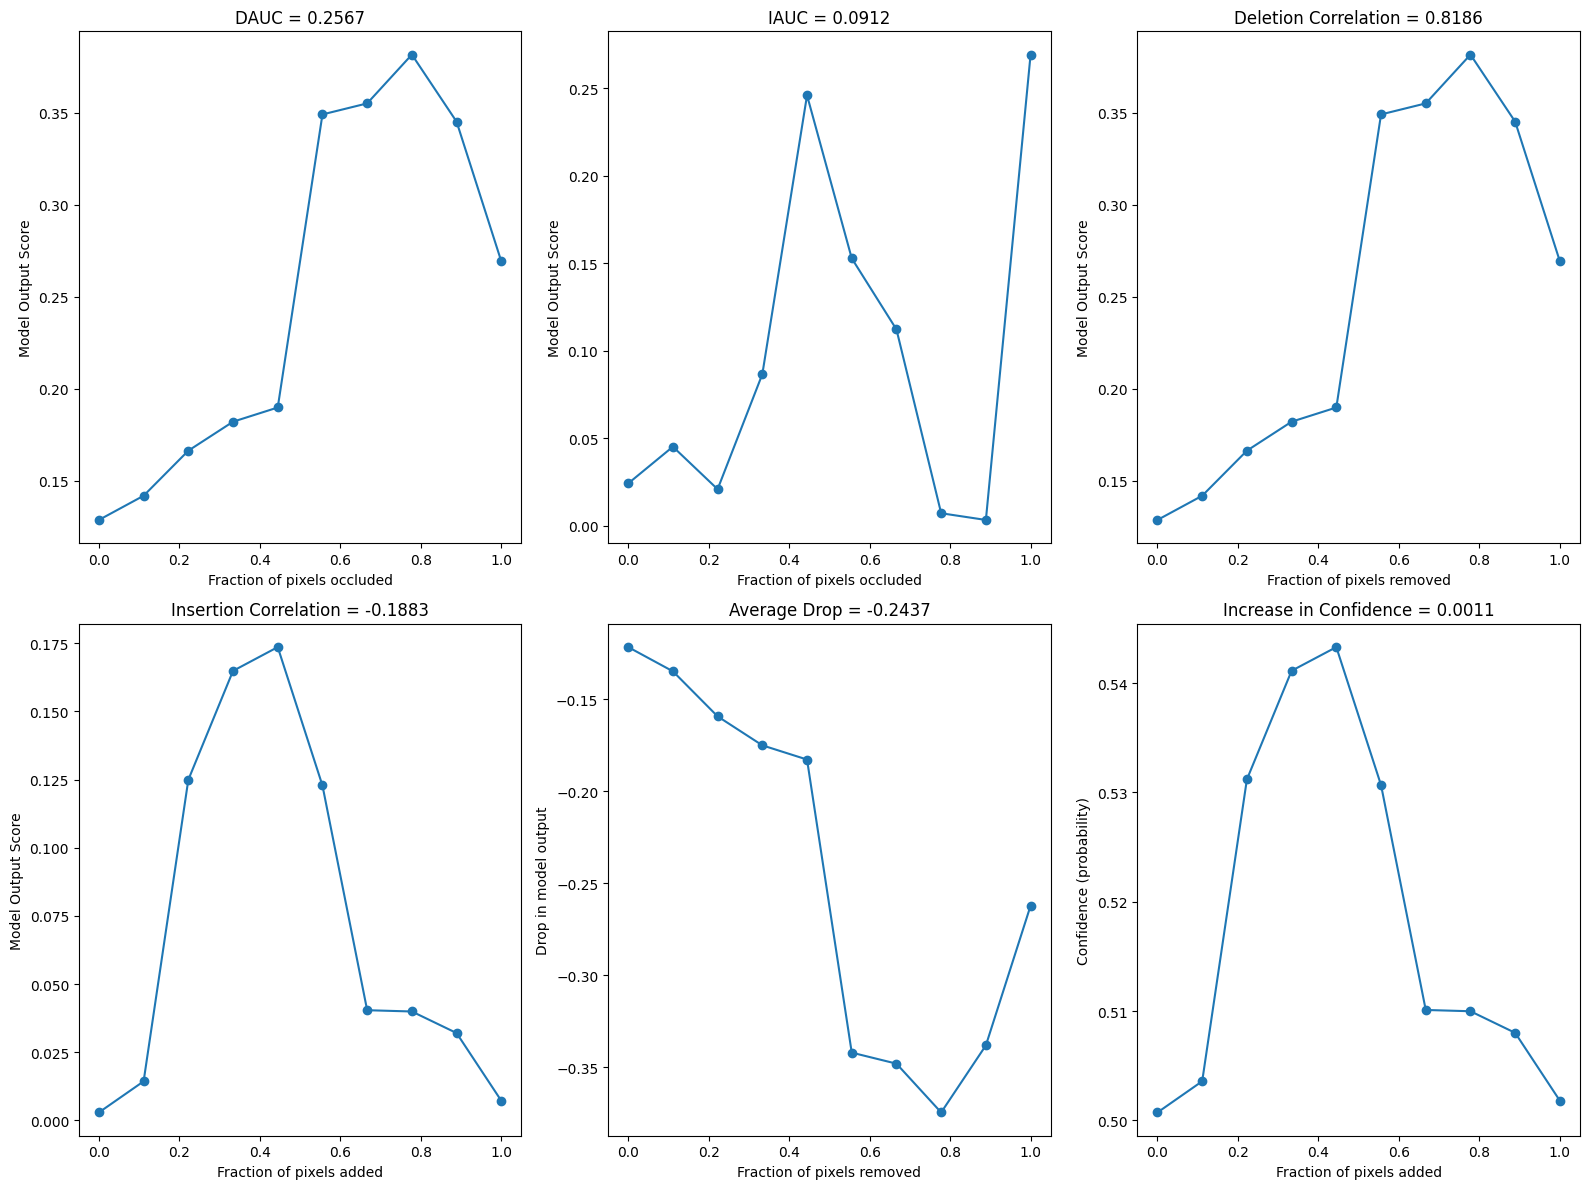


LIME Metrics Summary:
DAUC: 0.2567
IAUC: 0.0912
Deletion Correlation: 0.8186
Insertion Correlation: -0.1883
Average Drop: -0.2437
Increase in Confidence: 0.0011

Computing batch metrics on 200 images...


Computing LIME metrics:   0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\sonbu\AppData\Local\Temp\ipykernel_28716\211464218.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_value = np.trapz(perturbation_curve, x_vals)
Computing LIME metrics:   0%|          | 1/200 [00:06<22:05,  6.66s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\sonbu\AppData\Local\Temp\ipykernel_28716\211464218.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_value = np.trapz(perturbation_curve, x_vals)
Computing LIME metrics:   1%|          | 2/200 [00:13<22:09,  6.72s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\sonbu\AppData\Local\Temp\ipykernel_28716\211464218.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_value = np.trapz(perturbation_curve, x_vals)
Computing LIME metrics:   2%|▏         | 3/200 [00:33<42:26, 12.93s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\sonbu\AppData\Local\Temp\ipykernel_28716\211464218.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_value = np.trapz(perturbation_curve, x_vals)
Computing LIME metrics:   2%|▏         | 4/200 [00:53<50:41, 15.52s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\sonbu\AppData\Local\Temp\ipykernel_28716\211464218.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_value = np.trapz(perturbation_curve, x_vals)
Computing LIME metrics:   2%|▎         | 5/200 [01:14<57:22, 17.65s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\sonbu\AppData\Local\Temp\ipykernel_28716\211464218.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_value = np.trapz(perturbation_curve, x_vals)
Computing LIME metrics:   3%|▎         | 6/200 [01:34<59:29, 18.40s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\sonbu\AppData\Local\Temp\ipykernel_28716\211464218.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_value = np.trapz(perturbation_curve, x_vals)
Computing LIME metrics:   4%|▎         | 7/200 [01:55<1:01:35, 19.15s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\sonbu\AppData\Local\Temp\ipykernel_28716\211464218.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_value = np.trapz(perturbation_curve, x_vals)
Computing LIME metrics:   4%|▍         | 8/200 [02:15<1:02:52, 19.65s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\sonbu\AppData\Local\Temp\ipykernel_28716\211464218.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_value = np.trapz(perturbation_curve, x_vals)
Computing LIME metrics:   4%|▍         | 9/200 [02:37<1:04:07, 20.14s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\sonbu\AppData\Local\Temp\ipykernel_28716\211464218.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_value = np.trapz(perturbation_curve, x_vals)
Computing LIME metrics:   5%|▌         | 10/200 [02:58<1:04:31, 20.38s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\sonbu\AppData\Local\Temp\ipykernel_28716\211464218.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_value = np.trapz(perturbation_curve, x_vals)
Computing LIME metrics:   6%|▌         | 11/200 [03:18<1:04:10, 20.37s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\sonbu\AppData\Local\Temp\ipykernel_28716\211464218.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_value = np.trapz(perturbation_curve, x_vals)
Computing LIME metrics:   6%|▌         | 12/200 [03:38<1:03:38, 20.31s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\sonbu\AppData\Local\Temp\ipykernel_28716\211464218.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_value = np.trapz(perturbation_curve, x_vals)
Computing LIME metrics:   6%|▋         | 13/200 [03:58<1:03:02, 20.23s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\sonbu\AppData\Local\Temp\ipykernel_28716\211464218.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_value = np.trapz(perturbation_curve, x_vals)
Computing LIME metrics:   7%|▋         | 14/200 [04:18<1:02:31, 20.17s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\sonbu\AppData\Local\Temp\ipykernel_28716\211464218.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_value = np.trapz(perturbation_curve, x_vals)
Computing LIME metrics:   8%|▊         | 15/200 [04:38<1:02:11, 20.17s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\sonbu\AppData\Local\Temp\ipykernel_28716\211464218.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_value = np.trapz(perturbation_curve, x_vals)
Computing LIME metrics:   8%|▊         | 16/200 [04:59<1:01:57, 20.20s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\sonbu\AppData\Local\Temp\ipykernel_28716\211464218.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_value = np.trapz(perturbation_curve, x_vals)
Computing LIME metrics:   8%|▊         | 17/200 [05:19<1:01:56, 20.31s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\sonbu\AppData\Local\Temp\ipykernel_28716\211464218.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_value = np.trapz(perturbation_curve, x_vals)
Computing LIME metrics:   9%|▉         | 18/200 [05:38<1:00:12, 19.85s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\sonbu\AppData\Local\Temp\ipykernel_28716\211464218.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_value = np.trapz(perturbation_curve, x_vals)
Computing LIME metrics:  10%|▉         | 19/200 [05:57<59:23, 19.69s/it]  

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\sonbu\AppData\Local\Temp\ipykernel_28716\211464218.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_value = np.trapz(perturbation_curve, x_vals)
Computing LIME metrics:  10%|█         | 20/200 [06:16<57:58, 19.32s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\sonbu\AppData\Local\Temp\ipykernel_28716\211464218.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_value = np.trapz(perturbation_curve, x_vals)
Computing LIME metrics:  10%|█         | 21/200 [06:35<57:47, 19.37s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\sonbu\AppData\Local\Temp\ipykernel_28716\211464218.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_value = np.trapz(perturbation_curve, x_vals)
Computing LIME metrics:  11%|█         | 22/200 [07:13<1:14:14, 25.03s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\sonbu\AppData\Local\Temp\ipykernel_28716\211464218.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_value = np.trapz(perturbation_curve, x_vals)
Computing LIME metrics:  12%|█▏        | 23/200 [08:00<1:33:15, 31.61s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\sonbu\AppData\Local\Temp\ipykernel_28716\211464218.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_value = np.trapz(perturbation_curve, x_vals)
Computing LIME metrics:  12%|█▏        | 24/200 [08:50<1:48:32, 37.00s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\sonbu\AppData\Local\Temp\ipykernel_28716\211464218.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_value = np.trapz(perturbation_curve, x_vals)
Computing LIME metrics:  12%|█▎        | 25/200 [09:17<1:39:33, 34.13s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\sonbu\AppData\Local\Temp\ipykernel_28716\211464218.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_value = np.trapz(perturbation_curve, x_vals)
Computing LIME metrics:  13%|█▎        | 26/200 [09:35<1:24:56, 29.29s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\sonbu\AppData\Local\Temp\ipykernel_28716\211464218.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_value = np.trapz(perturbation_curve, x_vals)
Computing LIME metrics:  14%|█▎        | 27/200 [09:54<1:15:07, 26.05s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\sonbu\AppData\Local\Temp\ipykernel_28716\211464218.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_value = np.trapz(perturbation_curve, x_vals)
Computing LIME metrics:  14%|█▍        | 28/200 [10:12<1:08:06, 23.76s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\sonbu\AppData\Local\Temp\ipykernel_28716\211464218.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_value = np.trapz(perturbation_curve, x_vals)
Computing LIME metrics:  14%|█▍        | 29/200 [10:30<1:02:20, 21.88s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\sonbu\AppData\Local\Temp\ipykernel_28716\211464218.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_value = np.trapz(perturbation_curve, x_vals)
Computing LIME metrics:  15%|█▌        | 30/200 [10:48<58:59, 20.82s/it]  

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\sonbu\AppData\Local\Temp\ipykernel_28716\211464218.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_value = np.trapz(perturbation_curve, x_vals)
Computing LIME metrics:  16%|█▌        | 31/200 [11:06<56:16, 19.98s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\sonbu\AppData\Local\Temp\ipykernel_28716\211464218.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_value = np.trapz(perturbation_curve, x_vals)
Computing LIME metrics:  16%|█▌        | 32/200 [11:25<54:42, 19.54s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\sonbu\AppData\Local\Temp\ipykernel_28716\211464218.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_value = np.trapz(perturbation_curve, x_vals)
Computing LIME metrics:  16%|█▋        | 33/200 [11:42<52:53, 19.01s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\sonbu\AppData\Local\Temp\ipykernel_28716\211464218.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_value = np.trapz(perturbation_curve, x_vals)
Computing LIME metrics:  17%|█▋        | 34/200 [12:01<52:02, 18.81s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\sonbu\AppData\Local\Temp\ipykernel_28716\211464218.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_value = np.trapz(perturbation_curve, x_vals)
Computing LIME metrics:  18%|█▊        | 35/200 [12:19<50:56, 18.53s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\sonbu\AppData\Local\Temp\ipykernel_28716\211464218.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_value = np.trapz(perturbation_curve, x_vals)
Computing LIME metrics:  18%|█▊        | 36/200 [12:38<50:59, 18.66s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\sonbu\AppData\Local\Temp\ipykernel_28716\211464218.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_value = np.trapz(perturbation_curve, x_vals)
Computing LIME metrics:  18%|█▊        | 37/200 [12:56<50:16, 18.51s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\sonbu\AppData\Local\Temp\ipykernel_28716\211464218.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_value = np.trapz(perturbation_curve, x_vals)
Computing LIME metrics:  19%|█▉        | 38/200 [13:14<49:36, 18.37s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\sonbu\AppData\Local\Temp\ipykernel_28716\211464218.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_value = np.trapz(perturbation_curve, x_vals)
Computing LIME metrics:  20%|█▉        | 39/200 [13:32<49:04, 18.29s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\sonbu\AppData\Local\Temp\ipykernel_28716\211464218.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_value = np.trapz(perturbation_curve, x_vals)
Computing LIME metrics:  20%|██        | 40/200 [13:51<49:31, 18.57s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\sonbu\AppData\Local\Temp\ipykernel_28716\211464218.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_value = np.trapz(perturbation_curve, x_vals)
Computing LIME metrics:  20%|██        | 41/200 [14:09<48:57, 18.48s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\sonbu\AppData\Local\Temp\ipykernel_28716\211464218.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_value = np.trapz(perturbation_curve, x_vals)
Computing LIME metrics:  21%|██        | 42/200 [14:28<48:21, 18.36s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\sonbu\AppData\Local\Temp\ipykernel_28716\211464218.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_value = np.trapz(perturbation_curve, x_vals)
Computing LIME metrics:  22%|██▏       | 43/200 [14:46<47:52, 18.30s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\sonbu\AppData\Local\Temp\ipykernel_28716\211464218.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_value = np.trapz(perturbation_curve, x_vals)
Computing LIME metrics:  22%|██▏       | 44/200 [15:05<48:00, 18.47s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\sonbu\AppData\Local\Temp\ipykernel_28716\211464218.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_value = np.trapz(perturbation_curve, x_vals)
Computing LIME metrics:  22%|██▎       | 45/200 [15:26<50:03, 19.38s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\sonbu\AppData\Local\Temp\ipykernel_28716\211464218.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_value = np.trapz(perturbation_curve, x_vals)
Computing LIME metrics:  23%|██▎       | 46/200 [15:46<50:08, 19.54s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\sonbu\AppData\Local\Temp\ipykernel_28716\211464218.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_value = np.trapz(perturbation_curve, x_vals)
Computing LIME metrics:  24%|██▎       | 47/200 [16:06<50:11, 19.68s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\sonbu\AppData\Local\Temp\ipykernel_28716\211464218.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_value = np.trapz(perturbation_curve, x_vals)
Computing LIME metrics:  24%|██▍       | 48/200 [16:26<49:48, 19.66s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\sonbu\AppData\Local\Temp\ipykernel_28716\211464218.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_value = np.trapz(perturbation_curve, x_vals)
Computing LIME metrics:  24%|██▍       | 49/200 [16:46<50:12, 19.95s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\sonbu\AppData\Local\Temp\ipykernel_28716\211464218.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_value = np.trapz(perturbation_curve, x_vals)
Computing LIME metrics:  25%|██▌       | 50/200 [17:06<49:57, 19.98s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\sonbu\AppData\Local\Temp\ipykernel_28716\211464218.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_value = np.trapz(perturbation_curve, x_vals)
Computing LIME metrics:  26%|██▌       | 51/200 [17:26<49:21, 19.88s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\sonbu\AppData\Local\Temp\ipykernel_28716\211464218.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_value = np.trapz(perturbation_curve, x_vals)
Computing LIME metrics:  26%|██▌       | 52/200 [17:45<48:15, 19.56s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\sonbu\AppData\Local\Temp\ipykernel_28716\211464218.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_value = np.trapz(perturbation_curve, x_vals)
Computing LIME metrics:  26%|██▋       | 53/200 [18:03<47:05, 19.22s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\sonbu\AppData\Local\Temp\ipykernel_28716\211464218.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_value = np.trapz(perturbation_curve, x_vals)
Computing LIME metrics:  27%|██▋       | 54/200 [18:22<46:44, 19.21s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\sonbu\AppData\Local\Temp\ipykernel_28716\211464218.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_value = np.trapz(perturbation_curve, x_vals)
Computing LIME metrics:  28%|██▊       | 55/200 [18:42<46:28, 19.23s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\sonbu\AppData\Local\Temp\ipykernel_28716\211464218.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_value = np.trapz(perturbation_curve, x_vals)
Computing LIME metrics:  28%|██▊       | 56/200 [19:02<46:38, 19.44s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\sonbu\AppData\Local\Temp\ipykernel_28716\211464218.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_value = np.trapz(perturbation_curve, x_vals)
Computing LIME metrics:  28%|██▊       | 57/200 [19:22<46:44, 19.61s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\sonbu\AppData\Local\Temp\ipykernel_28716\211464218.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_value = np.trapz(perturbation_curve, x_vals)
Computing LIME metrics:  29%|██▉       | 58/200 [19:41<46:16, 19.55s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\sonbu\AppData\Local\Temp\ipykernel_28716\211464218.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_value = np.trapz(perturbation_curve, x_vals)
Computing LIME metrics:  30%|██▉       | 59/200 [20:01<46:04, 19.60s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\sonbu\AppData\Local\Temp\ipykernel_28716\211464218.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_value = np.trapz(perturbation_curve, x_vals)
Computing LIME metrics:  30%|███       | 60/200 [20:20<45:48, 19.63s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\sonbu\AppData\Local\Temp\ipykernel_28716\211464218.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_value = np.trapz(perturbation_curve, x_vals)
Computing LIME metrics:  30%|███       | 61/200 [20:40<45:35, 19.68s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\sonbu\AppData\Local\Temp\ipykernel_28716\211464218.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_value = np.trapz(perturbation_curve, x_vals)
Computing LIME metrics:  31%|███       | 62/200 [21:00<45:25, 19.75s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\sonbu\AppData\Local\Temp\ipykernel_28716\211464218.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_value = np.trapz(perturbation_curve, x_vals)
Computing LIME metrics:  32%|███▏      | 63/200 [21:20<45:22, 19.87s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\sonbu\AppData\Local\Temp\ipykernel_28716\211464218.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_value = np.trapz(perturbation_curve, x_vals)
Computing LIME metrics:  32%|███▏      | 64/200 [21:40<44:58, 19.84s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\sonbu\AppData\Local\Temp\ipykernel_28716\211464218.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_value = np.trapz(perturbation_curve, x_vals)
Computing LIME metrics:  32%|███▎      | 65/200 [22:00<44:35, 19.82s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\sonbu\AppData\Local\Temp\ipykernel_28716\211464218.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_value = np.trapz(perturbation_curve, x_vals)
Computing LIME metrics:  33%|███▎      | 66/200 [22:20<44:20, 19.86s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\sonbu\AppData\Local\Temp\ipykernel_28716\211464218.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_value = np.trapz(perturbation_curve, x_vals)
Computing LIME metrics:  34%|███▎      | 67/200 [22:39<43:48, 19.76s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\sonbu\AppData\Local\Temp\ipykernel_28716\211464218.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_value = np.trapz(perturbation_curve, x_vals)
Computing LIME metrics:  34%|███▍      | 68/200 [22:59<43:31, 19.78s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\sonbu\AppData\Local\Temp\ipykernel_28716\211464218.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_value = np.trapz(perturbation_curve, x_vals)
Computing LIME metrics:  34%|███▍      | 69/200 [23:19<43:25, 19.89s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\sonbu\AppData\Local\Temp\ipykernel_28716\211464218.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_value = np.trapz(perturbation_curve, x_vals)
Computing LIME metrics:  35%|███▌      | 70/200 [23:39<42:48, 19.76s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\sonbu\AppData\Local\Temp\ipykernel_28716\211464218.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_value = np.trapz(perturbation_curve, x_vals)
Computing LIME metrics:  36%|███▌      | 71/200 [23:58<42:25, 19.73s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\sonbu\AppData\Local\Temp\ipykernel_28716\211464218.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_value = np.trapz(perturbation_curve, x_vals)
Computing LIME metrics:  36%|███▌      | 72/200 [24:18<42:01, 19.70s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\sonbu\AppData\Local\Temp\ipykernel_28716\211464218.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_value = np.trapz(perturbation_curve, x_vals)
Computing LIME metrics:  36%|███▋      | 73/200 [24:38<42:01, 19.85s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\sonbu\AppData\Local\Temp\ipykernel_28716\211464218.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_value = np.trapz(perturbation_curve, x_vals)
Computing LIME metrics:  37%|███▋      | 74/200 [24:59<42:03, 20.03s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\sonbu\AppData\Local\Temp\ipykernel_28716\211464218.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_value = np.trapz(perturbation_curve, x_vals)
Computing LIME metrics:  38%|███▊      | 75/200 [25:18<41:24, 19.87s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\sonbu\AppData\Local\Temp\ipykernel_28716\211464218.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_value = np.trapz(perturbation_curve, x_vals)
Computing LIME metrics:  38%|███▊      | 76/200 [25:38<40:58, 19.83s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\sonbu\AppData\Local\Temp\ipykernel_28716\211464218.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_value = np.trapz(perturbation_curve, x_vals)
Computing LIME metrics:  38%|███▊      | 77/200 [25:57<40:23, 19.70s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\sonbu\AppData\Local\Temp\ipykernel_28716\211464218.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_value = np.trapz(perturbation_curve, x_vals)
Computing LIME metrics:  39%|███▉      | 78/200 [26:18<40:33, 19.95s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\sonbu\AppData\Local\Temp\ipykernel_28716\211464218.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_value = np.trapz(perturbation_curve, x_vals)
Computing LIME metrics:  40%|███▉      | 79/200 [26:38<40:19, 20.00s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\sonbu\AppData\Local\Temp\ipykernel_28716\211464218.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_value = np.trapz(perturbation_curve, x_vals)
Computing LIME metrics:  40%|████      | 80/200 [26:58<40:12, 20.10s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\sonbu\AppData\Local\Temp\ipykernel_28716\211464218.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_value = np.trapz(perturbation_curve, x_vals)
Computing LIME metrics:  40%|████      | 81/200 [27:19<39:57, 20.15s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\sonbu\AppData\Local\Temp\ipykernel_28716\211464218.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_value = np.trapz(perturbation_curve, x_vals)
Computing LIME metrics:  41%|████      | 82/200 [27:40<40:10, 20.43s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\sonbu\AppData\Local\Temp\ipykernel_28716\211464218.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_value = np.trapz(perturbation_curve, x_vals)
Computing LIME metrics:  42%|████▏     | 83/200 [28:00<39:50, 20.43s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\sonbu\AppData\Local\Temp\ipykernel_28716\211464218.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_value = np.trapz(perturbation_curve, x_vals)
Computing LIME metrics:  42%|████▏     | 84/200 [28:20<39:19, 20.34s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\sonbu\AppData\Local\Temp\ipykernel_28716\211464218.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_value = np.trapz(perturbation_curve, x_vals)
Computing LIME metrics:  42%|████▎     | 85/200 [28:41<39:01, 20.36s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\sonbu\AppData\Local\Temp\ipykernel_28716\211464218.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_value = np.trapz(perturbation_curve, x_vals)
Computing LIME metrics:  43%|████▎     | 86/200 [29:01<38:33, 20.29s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\sonbu\AppData\Local\Temp\ipykernel_28716\211464218.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_value = np.trapz(perturbation_curve, x_vals)
Computing LIME metrics:  44%|████▎     | 87/200 [29:21<38:20, 20.36s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\sonbu\AppData\Local\Temp\ipykernel_28716\211464218.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_value = np.trapz(perturbation_curve, x_vals)
Computing LIME metrics:  44%|████▍     | 88/200 [29:41<37:56, 20.33s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\sonbu\AppData\Local\Temp\ipykernel_28716\211464218.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_value = np.trapz(perturbation_curve, x_vals)
Computing LIME metrics:  44%|████▍     | 89/200 [30:02<37:57, 20.52s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\sonbu\AppData\Local\Temp\ipykernel_28716\211464218.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_value = np.trapz(perturbation_curve, x_vals)
Computing LIME metrics:  45%|████▌     | 90/200 [30:24<38:12, 20.84s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\sonbu\AppData\Local\Temp\ipykernel_28716\211464218.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_value = np.trapz(perturbation_curve, x_vals)
Computing LIME metrics:  46%|████▌     | 91/200 [30:46<38:12, 21.04s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\sonbu\AppData\Local\Temp\ipykernel_28716\211464218.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_value = np.trapz(perturbation_curve, x_vals)
Computing LIME metrics:  46%|████▌     | 92/200 [31:06<37:25, 20.79s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\sonbu\AppData\Local\Temp\ipykernel_28716\211464218.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_value = np.trapz(perturbation_curve, x_vals)
Computing LIME metrics:  46%|████▋     | 93/200 [31:27<37:22, 20.95s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\sonbu\AppData\Local\Temp\ipykernel_28716\211464218.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_value = np.trapz(perturbation_curve, x_vals)
Computing LIME metrics:  47%|████▋     | 94/200 [31:48<37:06, 21.00s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\sonbu\AppData\Local\Temp\ipykernel_28716\211464218.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_value = np.trapz(perturbation_curve, x_vals)
Computing LIME metrics:  48%|████▊     | 95/200 [32:09<36:24, 20.81s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\sonbu\AppData\Local\Temp\ipykernel_28716\211464218.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_value = np.trapz(perturbation_curve, x_vals)
Computing LIME metrics:  48%|████▊     | 96/200 [32:30<36:21, 20.97s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\sonbu\AppData\Local\Temp\ipykernel_28716\211464218.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_value = np.trapz(perturbation_curve, x_vals)
Computing LIME metrics:  48%|████▊     | 97/200 [32:50<35:45, 20.83s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\sonbu\AppData\Local\Temp\ipykernel_28716\211464218.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_value = np.trapz(perturbation_curve, x_vals)
Computing LIME metrics:  49%|████▉     | 98/200 [33:11<35:17, 20.76s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\sonbu\AppData\Local\Temp\ipykernel_28716\211464218.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_value = np.trapz(perturbation_curve, x_vals)
Computing LIME metrics:  50%|████▉     | 99/200 [33:32<34:55, 20.75s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\sonbu\AppData\Local\Temp\ipykernel_28716\211464218.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_value = np.trapz(perturbation_curve, x_vals)
Computing LIME metrics:  50%|█████     | 100/200 [33:53<35:00, 21.01s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\sonbu\AppData\Local\Temp\ipykernel_28716\211464218.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_value = np.trapz(perturbation_curve, x_vals)
Computing LIME metrics:  50%|█████     | 101/200 [34:14<34:35, 20.97s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\sonbu\AppData\Local\Temp\ipykernel_28716\211464218.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_value = np.trapz(perturbation_curve, x_vals)
Computing LIME metrics:  51%|█████     | 102/200 [34:36<34:32, 21.14s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\sonbu\AppData\Local\Temp\ipykernel_28716\211464218.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_value = np.trapz(perturbation_curve, x_vals)
Computing LIME metrics:  52%|█████▏    | 103/200 [34:58<34:36, 21.40s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\sonbu\AppData\Local\Temp\ipykernel_28716\211464218.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_value = np.trapz(perturbation_curve, x_vals)
Computing LIME metrics:  52%|█████▏    | 104/200 [35:19<34:11, 21.37s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\sonbu\AppData\Local\Temp\ipykernel_28716\211464218.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_value = np.trapz(perturbation_curve, x_vals)
Computing LIME metrics:  52%|█████▎    | 105/200 [35:40<33:29, 21.15s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\sonbu\AppData\Local\Temp\ipykernel_28716\211464218.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_value = np.trapz(perturbation_curve, x_vals)
Computing LIME metrics:  53%|█████▎    | 106/200 [36:00<32:56, 21.03s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\sonbu\AppData\Local\Temp\ipykernel_28716\211464218.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_value = np.trapz(perturbation_curve, x_vals)
Computing LIME metrics:  54%|█████▎    | 107/200 [36:22<32:42, 21.11s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\sonbu\AppData\Local\Temp\ipykernel_28716\211464218.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_value = np.trapz(perturbation_curve, x_vals)
Computing LIME metrics:  54%|█████▍    | 108/200 [36:43<32:18, 21.07s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\sonbu\AppData\Local\Temp\ipykernel_28716\211464218.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_value = np.trapz(perturbation_curve, x_vals)
Computing LIME metrics:  55%|█████▍    | 109/200 [37:05<32:19, 21.31s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\sonbu\AppData\Local\Temp\ipykernel_28716\211464218.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_value = np.trapz(perturbation_curve, x_vals)
Computing LIME metrics:  55%|█████▌    | 110/200 [37:29<33:29, 22.33s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\sonbu\AppData\Local\Temp\ipykernel_28716\211464218.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_value = np.trapz(perturbation_curve, x_vals)
Computing LIME metrics:  56%|█████▌    | 111/200 [37:50<32:32, 21.94s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\sonbu\AppData\Local\Temp\ipykernel_28716\211464218.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_value = np.trapz(perturbation_curve, x_vals)
Computing LIME metrics:  56%|█████▌    | 112/200 [38:11<31:48, 21.69s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\sonbu\AppData\Local\Temp\ipykernel_28716\211464218.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_value = np.trapz(perturbation_curve, x_vals)
Computing LIME metrics:  56%|█████▋    | 113/200 [38:33<31:14, 21.55s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\sonbu\AppData\Local\Temp\ipykernel_28716\211464218.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_value = np.trapz(perturbation_curve, x_vals)
Computing LIME metrics:  57%|█████▋    | 114/200 [38:55<31:07, 21.72s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\sonbu\AppData\Local\Temp\ipykernel_28716\211464218.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_value = np.trapz(perturbation_curve, x_vals)
Computing LIME metrics:  57%|█████▊    | 115/200 [39:17<30:49, 21.76s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\sonbu\AppData\Local\Temp\ipykernel_28716\211464218.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_value = np.trapz(perturbation_curve, x_vals)
Computing LIME metrics:  58%|█████▊    | 116/200 [39:38<30:31, 21.80s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\sonbu\AppData\Local\Temp\ipykernel_28716\211464218.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_value = np.trapz(perturbation_curve, x_vals)
Computing LIME metrics:  58%|█████▊    | 117/200 [40:00<30:14, 21.86s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\sonbu\AppData\Local\Temp\ipykernel_28716\211464218.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_value = np.trapz(perturbation_curve, x_vals)
Computing LIME metrics:  59%|█████▉    | 118/200 [40:22<29:52, 21.86s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\sonbu\AppData\Local\Temp\ipykernel_28716\211464218.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_value = np.trapz(perturbation_curve, x_vals)
Computing LIME metrics:  60%|█████▉    | 119/200 [40:44<29:35, 21.91s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\sonbu\AppData\Local\Temp\ipykernel_28716\211464218.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_value = np.trapz(perturbation_curve, x_vals)
Computing LIME metrics:  60%|██████    | 120/200 [41:06<29:07, 21.84s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\sonbu\AppData\Local\Temp\ipykernel_28716\211464218.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_value = np.trapz(perturbation_curve, x_vals)
Computing LIME metrics:  60%|██████    | 121/200 [41:28<28:55, 21.97s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\sonbu\AppData\Local\Temp\ipykernel_28716\211464218.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_value = np.trapz(perturbation_curve, x_vals)
Computing LIME metrics:  61%|██████    | 122/200 [41:50<28:29, 21.91s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\sonbu\AppData\Local\Temp\ipykernel_28716\211464218.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_value = np.trapz(perturbation_curve, x_vals)
Computing LIME metrics:  62%|██████▏   | 123/200 [42:11<27:46, 21.64s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\sonbu\AppData\Local\Temp\ipykernel_28716\211464218.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_value = np.trapz(perturbation_curve, x_vals)
Computing LIME metrics:  62%|██████▏   | 124/200 [42:33<27:21, 21.60s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\sonbu\AppData\Local\Temp\ipykernel_28716\211464218.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_value = np.trapz(perturbation_curve, x_vals)
Computing LIME metrics:  62%|██████▎   | 125/200 [42:55<27:12, 21.77s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\sonbu\AppData\Local\Temp\ipykernel_28716\211464218.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_value = np.trapz(perturbation_curve, x_vals)
Computing LIME metrics:  63%|██████▎   | 126/200 [43:16<26:46, 21.71s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\sonbu\AppData\Local\Temp\ipykernel_28716\211464218.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_value = np.trapz(perturbation_curve, x_vals)
Computing LIME metrics:  64%|██████▎   | 127/200 [43:38<26:32, 21.81s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\sonbu\AppData\Local\Temp\ipykernel_28716\211464218.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_value = np.trapz(perturbation_curve, x_vals)
Computing LIME metrics:  64%|██████▍   | 128/200 [44:00<26:14, 21.86s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\sonbu\AppData\Local\Temp\ipykernel_28716\211464218.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_value = np.trapz(perturbation_curve, x_vals)
Computing LIME metrics:  64%|██████▍   | 129/200 [44:21<25:32, 21.59s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\sonbu\AppData\Local\Temp\ipykernel_28716\211464218.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_value = np.trapz(perturbation_curve, x_vals)
Computing LIME metrics:  65%|██████▌   | 130/200 [44:43<25:17, 21.68s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\sonbu\AppData\Local\Temp\ipykernel_28716\211464218.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_value = np.trapz(perturbation_curve, x_vals)
Computing LIME metrics:  66%|██████▌   | 131/200 [45:07<25:31, 22.19s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\sonbu\AppData\Local\Temp\ipykernel_28716\211464218.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_value = np.trapz(perturbation_curve, x_vals)
Computing LIME metrics:  66%|██████▌   | 132/200 [45:29<25:09, 22.20s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\sonbu\AppData\Local\Temp\ipykernel_28716\211464218.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_value = np.trapz(perturbation_curve, x_vals)
Computing LIME metrics:  66%|██████▋   | 133/200 [45:51<24:36, 22.04s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\sonbu\AppData\Local\Temp\ipykernel_28716\211464218.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_value = np.trapz(perturbation_curve, x_vals)
Computing LIME metrics:  67%|██████▋   | 134/200 [46:13<24:26, 22.21s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\sonbu\AppData\Local\Temp\ipykernel_28716\211464218.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_value = np.trapz(perturbation_curve, x_vals)
Computing LIME metrics:  68%|██████▊   | 135/200 [46:36<24:12, 22.35s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\sonbu\AppData\Local\Temp\ipykernel_28716\211464218.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_value = np.trapz(perturbation_curve, x_vals)
Computing LIME metrics:  68%|██████▊   | 136/200 [46:58<23:45, 22.27s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\sonbu\AppData\Local\Temp\ipykernel_28716\211464218.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_value = np.trapz(perturbation_curve, x_vals)
Computing LIME metrics:  68%|██████▊   | 137/200 [47:20<23:21, 22.25s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\sonbu\AppData\Local\Temp\ipykernel_28716\211464218.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_value = np.trapz(perturbation_curve, x_vals)
Computing LIME metrics:  69%|██████▉   | 138/200 [47:43<23:03, 22.32s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\sonbu\AppData\Local\Temp\ipykernel_28716\211464218.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_value = np.trapz(perturbation_curve, x_vals)
Computing LIME metrics:  70%|██████▉   | 139/200 [48:04<22:28, 22.10s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\sonbu\AppData\Local\Temp\ipykernel_28716\211464218.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_value = np.trapz(perturbation_curve, x_vals)
Computing LIME metrics:  70%|███████   | 140/200 [48:27<22:12, 22.20s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\sonbu\AppData\Local\Temp\ipykernel_28716\211464218.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_value = np.trapz(perturbation_curve, x_vals)
Computing LIME metrics:  70%|███████   | 141/200 [48:50<22:12, 22.58s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\sonbu\AppData\Local\Temp\ipykernel_28716\211464218.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_value = np.trapz(perturbation_curve, x_vals)
Computing LIME metrics:  71%|███████   | 142/200 [49:12<21:43, 22.47s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\sonbu\AppData\Local\Temp\ipykernel_28716\211464218.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_value = np.trapz(perturbation_curve, x_vals)
Computing LIME metrics:  72%|███████▏  | 143/200 [49:35<21:21, 22.47s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\sonbu\AppData\Local\Temp\ipykernel_28716\211464218.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_value = np.trapz(perturbation_curve, x_vals)
Computing LIME metrics:  72%|███████▏  | 144/200 [49:58<21:05, 22.60s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\sonbu\AppData\Local\Temp\ipykernel_28716\211464218.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_value = np.trapz(perturbation_curve, x_vals)
Computing LIME metrics:  72%|███████▎  | 145/200 [50:21<20:56, 22.84s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\sonbu\AppData\Local\Temp\ipykernel_28716\211464218.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_value = np.trapz(perturbation_curve, x_vals)
Computing LIME metrics:  73%|███████▎  | 146/200 [50:44<20:32, 22.83s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\sonbu\AppData\Local\Temp\ipykernel_28716\211464218.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_value = np.trapz(perturbation_curve, x_vals)
Computing LIME metrics:  74%|███████▎  | 147/200 [51:18<23:03, 26.10s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\sonbu\AppData\Local\Temp\ipykernel_28716\211464218.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_value = np.trapz(perturbation_curve, x_vals)
Computing LIME metrics:  74%|███████▍  | 148/200 [51:42<22:09, 25.57s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\sonbu\AppData\Local\Temp\ipykernel_28716\211464218.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_value = np.trapz(perturbation_curve, x_vals)
Computing LIME metrics:  74%|███████▍  | 149/200 [52:06<21:23, 25.17s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\sonbu\AppData\Local\Temp\ipykernel_28716\211464218.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_value = np.trapz(perturbation_curve, x_vals)
Computing LIME metrics:  75%|███████▌  | 150/200 [52:31<20:52, 25.05s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\sonbu\AppData\Local\Temp\ipykernel_28716\211464218.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_value = np.trapz(perturbation_curve, x_vals)
Computing LIME metrics:  76%|███████▌  | 151/200 [52:56<20:33, 25.18s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\sonbu\AppData\Local\Temp\ipykernel_28716\211464218.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_value = np.trapz(perturbation_curve, x_vals)
Computing LIME metrics:  76%|███████▌  | 152/200 [53:21<20:00, 25.01s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\sonbu\AppData\Local\Temp\ipykernel_28716\211464218.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_value = np.trapz(perturbation_curve, x_vals)
Computing LIME metrics:  76%|███████▋  | 153/200 [53:46<19:28, 24.85s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\sonbu\AppData\Local\Temp\ipykernel_28716\211464218.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_value = np.trapz(perturbation_curve, x_vals)
Computing LIME metrics:  77%|███████▋  | 154/200 [54:11<19:13, 25.07s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\sonbu\AppData\Local\Temp\ipykernel_28716\211464218.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_value = np.trapz(perturbation_curve, x_vals)
Computing LIME metrics:  78%|███████▊  | 155/200 [54:36<18:43, 24.96s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\sonbu\AppData\Local\Temp\ipykernel_28716\211464218.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_value = np.trapz(perturbation_curve, x_vals)
Computing LIME metrics:  78%|███████▊  | 156/200 [55:00<18:12, 24.83s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\sonbu\AppData\Local\Temp\ipykernel_28716\211464218.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_value = np.trapz(perturbation_curve, x_vals)
Computing LIME metrics:  78%|███████▊  | 157/200 [55:27<18:06, 25.26s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\sonbu\AppData\Local\Temp\ipykernel_28716\211464218.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_value = np.trapz(perturbation_curve, x_vals)
Computing LIME metrics:  79%|███████▉  | 158/200 [55:52<17:46, 25.39s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\sonbu\AppData\Local\Temp\ipykernel_28716\211464218.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_value = np.trapz(perturbation_curve, x_vals)
Computing LIME metrics:  80%|███████▉  | 159/200 [56:18<17:24, 25.46s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\sonbu\AppData\Local\Temp\ipykernel_28716\211464218.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_value = np.trapz(perturbation_curve, x_vals)
Computing LIME metrics:  80%|████████  | 160/200 [56:44<17:06, 25.66s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\sonbu\AppData\Local\Temp\ipykernel_28716\211464218.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_value = np.trapz(perturbation_curve, x_vals)
Computing LIME metrics:  80%|████████  | 161/200 [57:09<16:31, 25.43s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\sonbu\AppData\Local\Temp\ipykernel_28716\211464218.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_value = np.trapz(perturbation_curve, x_vals)
Computing LIME metrics:  81%|████████  | 162/200 [57:34<16:00, 25.28s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\sonbu\AppData\Local\Temp\ipykernel_28716\211464218.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_value = np.trapz(perturbation_curve, x_vals)
Computing LIME metrics:  82%|████████▏ | 163/200 [58:00<15:43, 25.51s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\sonbu\AppData\Local\Temp\ipykernel_28716\211464218.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_value = np.trapz(perturbation_curve, x_vals)
Computing LIME metrics:  82%|████████▏ | 164/200 [58:25<15:11, 25.33s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\sonbu\AppData\Local\Temp\ipykernel_28716\211464218.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_value = np.trapz(perturbation_curve, x_vals)
Computing LIME metrics:  82%|████████▎ | 165/200 [58:50<14:44, 25.27s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\sonbu\AppData\Local\Temp\ipykernel_28716\211464218.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_value = np.trapz(perturbation_curve, x_vals)
Computing LIME metrics:  83%|████████▎ | 166/200 [59:16<14:22, 25.38s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\sonbu\AppData\Local\Temp\ipykernel_28716\211464218.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_value = np.trapz(perturbation_curve, x_vals)
Computing LIME metrics:  84%|████████▎ | 167/200 [59:41<13:57, 25.39s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\sonbu\AppData\Local\Temp\ipykernel_28716\211464218.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_value = np.trapz(perturbation_curve, x_vals)
Computing LIME metrics:  84%|████████▍ | 168/200 [1:00:06<13:25, 25.18s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\sonbu\AppData\Local\Temp\ipykernel_28716\211464218.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_value = np.trapz(perturbation_curve, x_vals)
Computing LIME metrics:  84%|████████▍ | 169/200 [1:00:31<13:03, 25.26s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\sonbu\AppData\Local\Temp\ipykernel_28716\211464218.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_value = np.trapz(perturbation_curve, x_vals)
Computing LIME metrics:  85%|████████▌ | 170/200 [1:00:58<12:48, 25.63s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\sonbu\AppData\Local\Temp\ipykernel_28716\211464218.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_value = np.trapz(perturbation_curve, x_vals)
Computing LIME metrics:  86%|████████▌ | 171/200 [1:01:22<12:16, 25.39s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\sonbu\AppData\Local\Temp\ipykernel_28716\211464218.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_value = np.trapz(perturbation_curve, x_vals)
Computing LIME metrics:  86%|████████▌ | 172/200 [1:01:47<11:47, 25.28s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\sonbu\AppData\Local\Temp\ipykernel_28716\211464218.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_value = np.trapz(perturbation_curve, x_vals)
Computing LIME metrics:  86%|████████▋ | 173/200 [1:02:14<11:30, 25.59s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\sonbu\AppData\Local\Temp\ipykernel_28716\211464218.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_value = np.trapz(perturbation_curve, x_vals)
Computing LIME metrics:  87%|████████▋ | 174/200 [1:02:39<11:02, 25.46s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\sonbu\AppData\Local\Temp\ipykernel_28716\211464218.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_value = np.trapz(perturbation_curve, x_vals)
Computing LIME metrics:  88%|████████▊ | 175/200 [1:03:04<10:33, 25.33s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\sonbu\AppData\Local\Temp\ipykernel_28716\211464218.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_value = np.trapz(perturbation_curve, x_vals)
Computing LIME metrics:  88%|████████▊ | 176/200 [1:03:31<10:17, 25.71s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\sonbu\AppData\Local\Temp\ipykernel_28716\211464218.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_value = np.trapz(perturbation_curve, x_vals)
Computing LIME metrics:  88%|████████▊ | 177/200 [1:03:56<09:46, 25.51s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\sonbu\AppData\Local\Temp\ipykernel_28716\211464218.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_value = np.trapz(perturbation_curve, x_vals)
Computing LIME metrics:  89%|████████▉ | 178/200 [1:04:22<09:26, 25.75s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\sonbu\AppData\Local\Temp\ipykernel_28716\211464218.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_value = np.trapz(perturbation_curve, x_vals)
Computing LIME metrics:  90%|████████▉ | 179/200 [1:04:49<09:06, 26.02s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\sonbu\AppData\Local\Temp\ipykernel_28716\211464218.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_value = np.trapz(perturbation_curve, x_vals)
Computing LIME metrics:  90%|█████████ | 180/200 [1:05:14<08:36, 25.82s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\sonbu\AppData\Local\Temp\ipykernel_28716\211464218.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_value = np.trapz(perturbation_curve, x_vals)
Computing LIME metrics:  90%|█████████ | 181/200 [1:05:39<08:09, 25.74s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\sonbu\AppData\Local\Temp\ipykernel_28716\211464218.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_value = np.trapz(perturbation_curve, x_vals)
Computing LIME metrics:  91%|█████████ | 182/200 [1:06:06<07:48, 26.05s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\sonbu\AppData\Local\Temp\ipykernel_28716\211464218.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_value = np.trapz(perturbation_curve, x_vals)
Computing LIME metrics:  92%|█████████▏| 183/200 [1:06:32<07:19, 25.85s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\sonbu\AppData\Local\Temp\ipykernel_28716\211464218.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_value = np.trapz(perturbation_curve, x_vals)
Computing LIME metrics:  92%|█████████▏| 184/200 [1:06:57<06:50, 25.65s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\sonbu\AppData\Local\Temp\ipykernel_28716\211464218.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_value = np.trapz(perturbation_curve, x_vals)
Computing LIME metrics:  92%|█████████▎| 185/200 [1:07:23<06:28, 25.88s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\sonbu\AppData\Local\Temp\ipykernel_28716\211464218.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_value = np.trapz(perturbation_curve, x_vals)
Computing LIME metrics:  93%|█████████▎| 186/200 [1:07:49<06:00, 25.75s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\sonbu\AppData\Local\Temp\ipykernel_28716\211464218.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_value = np.trapz(perturbation_curve, x_vals)
Computing LIME metrics:  94%|█████████▎| 187/200 [1:08:13<05:30, 25.46s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\sonbu\AppData\Local\Temp\ipykernel_28716\211464218.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_value = np.trapz(perturbation_curve, x_vals)
Computing LIME metrics:  94%|█████████▍| 188/200 [1:08:40<05:09, 25.82s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\sonbu\AppData\Local\Temp\ipykernel_28716\211464218.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_value = np.trapz(perturbation_curve, x_vals)
Computing LIME metrics:  94%|█████████▍| 189/200 [1:09:08<04:49, 26.29s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\sonbu\AppData\Local\Temp\ipykernel_28716\211464218.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_value = np.trapz(perturbation_curve, x_vals)
Computing LIME metrics:  95%|█████████▌| 190/200 [1:09:33<04:20, 26.09s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\sonbu\AppData\Local\Temp\ipykernel_28716\211464218.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_value = np.trapz(perturbation_curve, x_vals)
Computing LIME metrics:  96%|█████████▌| 191/200 [1:10:00<03:56, 26.24s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\sonbu\AppData\Local\Temp\ipykernel_28716\211464218.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_value = np.trapz(perturbation_curve, x_vals)
Computing LIME metrics:  96%|█████████▌| 192/200 [1:10:25<03:28, 26.01s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\sonbu\AppData\Local\Temp\ipykernel_28716\211464218.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_value = np.trapz(perturbation_curve, x_vals)
Computing LIME metrics:  96%|█████████▋| 193/200 [1:10:50<03:00, 25.77s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\sonbu\AppData\Local\Temp\ipykernel_28716\211464218.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_value = np.trapz(perturbation_curve, x_vals)
Computing LIME metrics:  97%|█████████▋| 194/200 [1:11:17<02:36, 26.11s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\sonbu\AppData\Local\Temp\ipykernel_28716\211464218.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_value = np.trapz(perturbation_curve, x_vals)
Computing LIME metrics:  98%|█████████▊| 195/200 [1:11:43<02:09, 26.00s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\sonbu\AppData\Local\Temp\ipykernel_28716\211464218.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_value = np.trapz(perturbation_curve, x_vals)
Computing LIME metrics:  98%|█████████▊| 196/200 [1:12:08<01:43, 25.79s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\sonbu\AppData\Local\Temp\ipykernel_28716\211464218.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_value = np.trapz(perturbation_curve, x_vals)
Computing LIME metrics:  98%|█████████▊| 197/200 [1:12:35<01:18, 26.08s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\sonbu\AppData\Local\Temp\ipykernel_28716\211464218.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_value = np.trapz(perturbation_curve, x_vals)
Computing LIME metrics:  99%|█████████▉| 198/200 [1:12:59<00:50, 25.35s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\sonbu\AppData\Local\Temp\ipykernel_28716\211464218.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_value = np.trapz(perturbation_curve, x_vals)
Computing LIME metrics: 100%|█████████▉| 199/200 [1:13:22<00:24, 24.87s/it]

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\sonbu\AppData\Local\Temp\ipykernel_28716\211464218.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_value = np.trapz(perturbation_curve, x_vals)
Computing LIME metrics: 100%|██████████| 200/200 [1:13:46<00:00, 22.13s/it]


Average Metrics across 200 images:
Average DAUC: 0.3614
Average IAUC: 0.4160
Average Deletion Correlation: -0.0688
Average Insertion Correlation: 0.1084
Average Average Drop: 0.1067
Average Increase in Confidence: 0.0348


In [11]:
def main():
    model = load_model()
    val_dataset, val_loader = load_data()
    
    explainer = lime_image.LimeImageExplainer()
    
    idx = 0
    image_tensor, _ = val_dataset[idx]
    input_image = image_tensor.unsqueeze(0).to(device)
    
    explanation, output, predicted_class = get_lime_explanation(input_image, explainer, model)
    
    visualize_lime_explanation(image_tensor, explanation, predicted_class)
    
    visualize_lime_metrics(model, input_image, explanation, output, predicted_class, steps=10)
    
    print("\nComputing batch metrics on 200 images...")
    results = batch_lime_metrics(model, val_dataset, num_images=200, steps=10)
    
    print("\nAverage Metrics across 200 images:")
    for metric, value in results.items():
        print(f"Average {metric}: {value:.4f}")

if __name__ == "__main__":
    model = load_model()
    main()